In [1]:
## MODULES TO IMPORT ##
import numpy as np
import os
from tqdm import tqdm
import model.dataset_utils as dataset_utils
import logging
import torch
import torch.optim as optim
from torch.autograd import Variable
from transformers import get_cosine_schedule_with_warmup
import model.utils as utils
import model.net as net
import model.data_loader as data_loader
from model.train import train_and_evaluate
import model.evaluate as evaluate
from model.evaluate import evaluate as evaluate2
import pandas as pd

C:\Users\vn71838\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vn71838\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\vn71838\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vn71838\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
## FUNCTION TO BUILD THE TRAINING AND VALIDATION DATASETS ##
def build_datasets(data_dir, output_dir, train_prop=0.9, config=None):

    assert os.path.isdir(data_dir), "Couldn't find the dataset at {}".format(data_dir)
    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    else:
        raise RuntimeError('{} already exists!'.format(output_dir))
            
    #Intialise a random number generator for reproducible experiments
    rng = np.random.default_rng(config['seed'])

    # Get the filenames in directory
    filenames = os.listdir(data_dir)
    filenames = [os.path.join(data_dir, f) for f in filenames if f.endswith('.txt')]

    # Split the recordings into train and val
    # Make sure to always shuffle with a fixed seed so that the split is reproducible
    filenames.sort()
    rng.shuffle(filenames)

    split = int(train_prop * len(filenames))

    train_filenames = filenames[:split]
    val_filenames = filenames[split:]

    filenames_dict = {'train': train_filenames,
                      'val': val_filenames}

    for split in ['train', 'val']:
        print('{}: {} recordings'.format(split, len(filenames_dict[split])))

    # Preprocess train, val
    for split in ['train', 'val']:
        output_dir_split = os.path.join(output_dir, '{}_npz'.format(split))
        if not os.path.exists(output_dir_split):
            os.makedirs(output_dir_split, exist_ok=True)
        else:
            print("Warning: dir {} already exists".format(output_dir_split))

        print("Processing {} data, saving preprocessed data to {}".format(split, output_dir_split))
        for filename in tqdm(filenames_dict[split]):
            dataset_utils.save_presence(filename, data_dir, output_dir_split, config)
            dataset_utils.save_absence(filename, data_dir, output_dir_split, rng, config)

    print("Done building datasets")
    
data_dir = 'data/labelled' # recordings with txt labels
output_dir = 'data/retraining_clips' # output directory - will create this automatically

## VALUES YOU CAN TO SET MANUALLY ##
train_proportion = 0.9 # Can set to a different value
config = {'sr': 24000, 'duration': 4.0, 'num_absence': 50, 'pad': 1, 'seed': 12345}
build_datasets(data_dir, output_dir, train_prop=train_proportion, config=config)

RuntimeError: data/retraining_clips already exists!

In [3]:
## FUNCTIONS TO RE-TRAIN THE MODEL ##
def batch_to_device(batch, device):
    batch_dict = {key: batch[key].to(device) for key in batch}
    return batch_dict

def get_scheduler(optimizer, total_steps, params):
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=params.warmup * (total_steps // params.batch_size),
        num_training_steps=params.num_epochs * (total_steps // params.batch_size),
    )
    return scheduler

def model_trainer(model_dir, data_dir, restore_file=None):

    # Load the parameters from json file
    json_path = os.path.join(model_dir, 'params.json')
    assert os.path.isfile(
        json_path), "No json configuration file found at {}".format(json_path)
    params = utils.Params(json_path)

    # use GPU if available
    params.cuda = torch.cuda.is_available()

    # Set the random seed for reproducible experiments
    torch.manual_seed(params.seed)
    if params.cuda:
        torch.cuda.manual_seed(params.seed)

    # Set the logger
    utils.set_logger(os.path.join(model_dir, 'train.log'))

    # Create the input data pipeline
    logging.info("Loading the datasets...")

    logging.info("GPU: {}".format(params.cuda))

    # fetch dataloaders
    dataloaders = data_loader.fetch_dataloader(
        ['train', 'val'], data_dir, params)
    train_dl = dataloaders['train']
    val_dl = dataloaders['val']
    logging.info("num_train: {}, num_val: {}".format(len(train_dl.dataset), len(val_dl.dataset)))

    logging.info("- done.")

    # Define the model and optimizer
    model = net.Net(params).cuda() if params.cuda else net.Net(params)
    
    # using Adam defaults from: https://docs.fast.ai/optimizer.html#Adam
    optimizer = optim.AdamW(model.parameters(), lr=params.learning_rate, betas=(0.9, 0.99), eps=1e-05, weight_decay=params.weight_decay)

    total_steps = len(train_dl.dataset)
    scheduler = get_scheduler(optimizer, total_steps, params)

    # fetch loss function and metrics
    loss_fn = net.loss_fn
    metrics = net.metrics

    # Train the model
    logging.info("Starting training for {} epoch(s)".format(params.num_epochs))
    train_and_evaluate(model, train_dl, val_dl, optimizer, scheduler, loss_fn, metrics, params, model_dir,
                       restore_file)


def train_model(model_dir, data_dir):
    # Load the "reference" parameters from parent_dir json file
    json_path = os.path.join(model_dir, 'params.json')
    assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
    params = utils.Params(json_path)
    model_trainer(model_dir, data_dir)

model_dir = 'experiments/retraining_model' # needs params.json file
data_dir = 'data/retraining_clips'
train_model(model_dir, data_dir)

Loading the datasets...
GPU: False
num_train: 13376, num_val: 1406
- done.


sound files available for data augmentation: 7420


Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/ecanfnet_l0_ra2-e3e9ac50.pth)
Converted input conv stem.conv1 pretrained weights from 3 to 2 channel(s)
Starting training for 30 epoch(s)
Epoch 1/30
  0%|                                                                                          | 0/418 [00:00<?, ?it/s]C:\Users\vn71838\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:25:12<00:00, 20.84s/it, loss=0.2778]
- Train metrics: loss: 0.4646 ; clip_loss: 0.4344 ; focal_loss: 0.0302
100%|██████████████

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 2/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:26:12<00:00, 20.99s/it, loss=0.1947]
- Train metrics: loss: 0.1420 ; clip_loss: 0.1385 ; focal_loss: 0.0035
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:24<00:00,  6.01s/it]
- Eval metrics : loss: 0.1492 ; average_precision: 0.9909 ; precision: 0.9388 ; recall: 0.9658 ; F-beta: 0.9521


Checkpoint Directory exists! 


Epoch 3/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:58<00:00, 19.52s/it, loss=0.1832]
- Train metrics: loss: 0.2769 ; clip_loss: 0.2734 ; focal_loss: 0.0035
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:31<00:00,  6.18s/it]
- Eval metrics : loss: 0.1945 ; average_precision: 0.9759 ; precision: 0.9200 ; recall: 0.9514 ; F-beta: 0.9355


Checkpoint Directory exists! 


Epoch 4/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:16:59<00:00, 19.66s/it, loss=0.1723]
- Train metrics: loss: 0.1879 ; clip_loss: 0.1842 ; focal_loss: 0.0037
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:23<00:00,  5.99s/it]
- Eval metrics : loss: 0.1167 ; average_precision: 0.9945 ; precision: 0.9799 ; recall: 0.9640 ; F-beta: 0.9719


Checkpoint Directory exists! 


- Found new best accuracy
Epoch 5/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:51<00:00, 19.50s/it, loss=0.1596]
- Train metrics: loss: 0.1791 ; clip_loss: 0.1752 ; focal_loss: 0.0038
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:21<00:00,  5.95s/it]
- Eval metrics : loss: 0.1147 ; average_precision: 0.9960 ; precision: 0.9833 ; recall: 0.9514 ; F-beta: 0.9671


Checkpoint Directory exists! 


Epoch 6/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:16:11<00:00, 19.55s/it, loss=0.1542]
- Train metrics: loss: 0.1640 ; clip_loss: 0.1608 ; focal_loss: 0.0033
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:20<00:00,  5.93s/it]
- Eval metrics : loss: 0.1278 ; average_precision: 0.9912 ; precision: 0.9513 ; recall: 0.9838 ; F-beta: 0.9673


Checkpoint Directory exists! 


Epoch 7/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:24<00:00, 19.44s/it, loss=0.1469]
- Train metrics: loss: 0.1501 ; clip_loss: 0.1464 ; focal_loss: 0.0037
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:21<00:00,  5.95s/it]
- Eval metrics : loss: 0.1307 ; average_precision: 0.9916 ; precision: 0.9642 ; recall: 0.9676 ; F-beta: 0.9659


Checkpoint Directory exists! 


Epoch 8/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:10<00:00, 19.40s/it, loss=0.1436]
- Train metrics: loss: 0.1456 ; clip_loss: 0.1427 ; focal_loss: 0.0029
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:20<00:00,  5.93s/it]
- Eval metrics : loss: 0.1251 ; average_precision: 0.9869 ; precision: 0.9834 ; recall: 0.9568 ; F-beta: 0.9699


Checkpoint Directory exists! 


Epoch 9/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:22<00:00, 19.43s/it, loss=0.1378]
- Train metrics: loss: 0.2233 ; clip_loss: 0.2203 ; focal_loss: 0.0029
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:21<00:00,  5.94s/it]
- Eval metrics : loss: 0.1136 ; average_precision: 0.9882 ; precision: 0.9729 ; recall: 0.9694 ; F-beta: 0.9712


Checkpoint Directory exists! 


Epoch 10/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:29<00:00, 19.45s/it, loss=0.1337]
- Train metrics: loss: 0.1565 ; clip_loss: 0.1536 ; focal_loss: 0.0029
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:23<00:00,  5.98s/it]
- Eval metrics : loss: 0.1349 ; average_precision: 0.9897 ; precision: 0.9591 ; recall: 0.9712 ; F-beta: 0.9651


Checkpoint Directory exists! 


Epoch 11/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:29<00:00, 19.45s/it, loss=0.1291]
- Train metrics: loss: 0.1086 ; clip_loss: 0.1058 ; focal_loss: 0.0029
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:22<00:00,  5.96s/it]
- Eval metrics : loss: 0.1461 ; average_precision: 0.9606 ; precision: 0.9481 ; recall: 0.9856 ; F-beta: 0.9665


Checkpoint Directory exists! 


Epoch 12/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:14:45<00:00, 19.34s/it, loss=0.1310]
- Train metrics: loss: 0.1325 ; clip_loss: 0.1294 ; focal_loss: 0.0031
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:21<00:00,  5.94s/it]
- Eval metrics : loss: 0.1233 ; average_precision: 0.9781 ; precision: 0.9658 ; recall: 0.9640 ; F-beta: 0.9649


Checkpoint Directory exists! 


Epoch 13/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:16<00:00, 19.42s/it, loss=0.1278]
- Train metrics: loss: 0.1043 ; clip_loss: 0.1016 ; focal_loss: 0.0028
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:20<00:00,  5.91s/it]
- Eval metrics : loss: 0.1411 ; average_precision: 0.9829 ; precision: 0.9622 ; recall: 0.9622 ; F-beta: 0.9622


Checkpoint Directory exists! 


Epoch 14/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:10<00:00, 19.40s/it, loss=0.1244]
- Train metrics: loss: 0.1349 ; clip_loss: 0.1315 ; focal_loss: 0.0034
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:21<00:00,  5.94s/it]
- Eval metrics : loss: 0.1403 ; average_precision: 0.9819 ; precision: 0.9494 ; recall: 0.9784 ; F-beta: 0.9637


Checkpoint Directory exists! 


Epoch 15/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:13<00:00, 19.41s/it, loss=0.1220]
- Train metrics: loss: 0.1502 ; clip_loss: 0.1471 ; focal_loss: 0.0031
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:20<00:00,  5.92s/it]
- Eval metrics : loss: 0.1026 ; average_precision: 0.9956 ; precision: 0.9767 ; recall: 0.9802 ; F-beta: 0.9785


Checkpoint Directory exists! 


- Found new best accuracy
Epoch 16/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:16:13<00:00, 19.55s/it, loss=0.1145]
- Train metrics: loss: 0.1084 ; clip_loss: 0.1056 ; focal_loss: 0.0028
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:21<00:00,  5.94s/it]
- Eval metrics : loss: 0.1174 ; average_precision: 0.9914 ; precision: 0.9696 ; recall: 0.9766 ; F-beta: 0.9731


Checkpoint Directory exists! 


Epoch 17/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:14:33<00:00, 19.31s/it, loss=0.1138]
- Train metrics: loss: 0.1168 ; clip_loss: 0.1138 ; focal_loss: 0.0030
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:21<00:00,  5.94s/it]
- Eval metrics : loss: 0.1193 ; average_precision: 0.9901 ; precision: 0.9731 ; recall: 0.9748 ; F-beta: 0.9739


Checkpoint Directory exists! 


Epoch 18/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:14<00:00, 19.41s/it, loss=0.1157]
- Train metrics: loss: 0.0948 ; clip_loss: 0.0918 ; focal_loss: 0.0031
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:20<00:00,  5.91s/it]
- Eval metrics : loss: 0.1282 ; average_precision: 0.9899 ; precision: 0.9746 ; recall: 0.9658 ; F-beta: 0.9702


Checkpoint Directory exists! 


Epoch 19/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:14:55<00:00, 19.37s/it, loss=0.1102]
- Train metrics: loss: 0.1354 ; clip_loss: 0.1320 ; focal_loss: 0.0034
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:21<00:00,  5.94s/it]
- Eval metrics : loss: 0.1354 ; average_precision: 0.9832 ; precision: 0.9745 ; recall: 0.9622 ; F-beta: 0.9683


Checkpoint Directory exists! 


Epoch 20/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:14:55<00:00, 19.37s/it, loss=0.1074]
- Train metrics: loss: 0.0953 ; clip_loss: 0.0924 ; focal_loss: 0.0029
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:21<00:00,  5.93s/it]
- Eval metrics : loss: 0.1278 ; average_precision: 0.9883 ; precision: 0.9763 ; recall: 0.9640 ; F-beta: 0.9701


Checkpoint Directory exists! 


Epoch 21/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:37<00:00, 19.47s/it, loss=0.1085]
- Train metrics: loss: 0.1016 ; clip_loss: 0.0990 ; focal_loss: 0.0027
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:21<00:00,  5.94s/it]
- Eval metrics : loss: 0.1259 ; average_precision: 0.9866 ; precision: 0.9644 ; recall: 0.9748 ; F-beta: 0.9696


Checkpoint Directory exists! 


Epoch 22/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:44<00:00, 19.48s/it, loss=0.1047]
- Train metrics: loss: 0.1383 ; clip_loss: 0.1351 ; focal_loss: 0.0032
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:20<00:00,  5.92s/it]
- Eval metrics : loss: 0.1284 ; average_precision: 0.9835 ; precision: 0.9694 ; recall: 0.9676 ; F-beta: 0.9685


Checkpoint Directory exists! 


Epoch 23/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:32<00:00, 19.45s/it, loss=0.1013]
- Train metrics: loss: 0.0947 ; clip_loss: 0.0921 ; focal_loss: 0.0026
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:21<00:00,  5.94s/it]
- Eval metrics : loss: 0.1283 ; average_precision: 0.9846 ; precision: 0.9609 ; recall: 0.9712 ; F-beta: 0.9660


Checkpoint Directory exists! 


Epoch 24/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:16<00:00, 19.42s/it, loss=0.1048]
- Train metrics: loss: 0.1017 ; clip_loss: 0.0991 ; focal_loss: 0.0026
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:20<00:00,  5.92s/it]
- Eval metrics : loss: 0.1241 ; average_precision: 0.9829 ; precision: 0.9629 ; recall: 0.9802 ; F-beta: 0.9715


Checkpoint Directory exists! 


Epoch 25/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:20<00:00, 19.43s/it, loss=0.1008]
- Train metrics: loss: 0.1122 ; clip_loss: 0.1096 ; focal_loss: 0.0026
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:22<00:00,  5.96s/it]
- Eval metrics : loss: 0.1325 ; average_precision: 0.9818 ; precision: 0.9642 ; recall: 0.9676 ; F-beta: 0.9659


Checkpoint Directory exists! 


Epoch 26/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:12<00:00, 19.41s/it, loss=0.1024]
- Train metrics: loss: 0.0979 ; clip_loss: 0.0953 ; focal_loss: 0.0026
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:21<00:00,  5.94s/it]
- Eval metrics : loss: 0.1249 ; average_precision: 0.9834 ; precision: 0.9642 ; recall: 0.9694 ; F-beta: 0.9668


Checkpoint Directory exists! 


Epoch 27/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:37<00:00, 19.47s/it, loss=0.0938]
- Train metrics: loss: 0.0838 ; clip_loss: 0.0814 ; focal_loss: 0.0024
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:19<00:00,  5.90s/it]
- Eval metrics : loss: 0.1264 ; average_precision: 0.9814 ; precision: 0.9643 ; recall: 0.9730 ; F-beta: 0.9687


Checkpoint Directory exists! 


Epoch 28/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:07<00:00, 19.40s/it, loss=0.0970]
- Train metrics: loss: 0.1002 ; clip_loss: 0.0976 ; focal_loss: 0.0026
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:21<00:00,  5.94s/it]
- Eval metrics : loss: 0.1243 ; average_precision: 0.9818 ; precision: 0.9644 ; recall: 0.9748 ; F-beta: 0.9696


Checkpoint Directory exists! 


Epoch 29/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:14:56<00:00, 19.37s/it, loss=0.0974]
- Train metrics: loss: 0.1252 ; clip_loss: 0.1225 ; focal_loss: 0.0027
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:23<00:00,  5.98s/it]
- Eval metrics : loss: 0.1250 ; average_precision: 0.9819 ; precision: 0.9644 ; recall: 0.9748 ; F-beta: 0.9696


Checkpoint Directory exists! 


Epoch 30/30
100%|█████████████████████████████████████████████████████████████████| 418/418 [2:15:41<00:00, 19.48s/it, loss=0.0964]
- Train metrics: loss: 0.0910 ; clip_loss: 0.0883 ; focal_loss: 0.0027
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [04:53<00:00,  6.67s/it]
- Eval metrics : loss: 0.1251 ; average_precision: 0.9819 ; precision: 0.9644 ; recall: 0.9748 ; F-beta: 0.9696


Checkpoint Directory exists! 


In [4]:
def evaluate_model(model_dir, data_dir, restore_file='best'):

    json_path = os.path.join(model_dir, 'params.json')
    assert os.path.isfile(
        json_path), "No json configuration file found at {}".format(json_path)
    params = utils.Params(json_path)
    params.cuda = torch.cuda.is_available()     # use GPU is available
    torch.manual_seed(params.seed)
    if params.cuda:
        torch.cuda.manual_seed(params.seed)

    # Get the logger
    utils.set_logger(os.path.join(model_dir, 'evaluate.log'))

    # Create the input data pipeline
    logging.info("Creating the dataset...")

    # fetch dataloaders
    dataloaders = data_loader.fetch_dataloader(['test'], data_dir, params)
    test_dl = dataloaders['test']
    logging.info("- done.")

    # Define the model
    model = net.Net(params).cuda() if params.cuda else net.Net(params)
    loss_fn = net.loss_fn
    metrics = net.metrics
    logging.info("Starting evaluation")

    # Reload weights from the saved file
    utils.load_checkpoint(os.path.join(
        model_dir, restore_file + '.pth.tar'), model)

    # Evaluate
    with torch.no_grad():
        test_metrics, logits = evaluate2(model, loss_fn, test_dl, metrics, params)
    save_path = os.path.join(
        model_dir, "metrics_test_{}.json".format(restore_file))
    utils.save_dict_to_json(test_metrics, save_path)
    
    # Write predictions to csv file
    save_path = os.path.join(
        model_dir, "outputs_test_{}.csv".format(restore_file))
    df = pd.DataFrame(list(zip(test_dl.dataset.filenames, test_dl.dataset.labels, logits)), columns =['file', 'targets', 'logits'])
    df.to_csv(save_path, index=False)
    
data_dir = 'data/retraining_clips'
model_dir = 'experiments/retraining_model'
evaluate_model(model_dir, data_dir, restore_file='best')

Creating the dataset...
- done.
Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/ecanfnet_l0_ra2-e3e9ac50.pth)
Converted input conv stem.conv1 pretrained weights from 3 to 2 channel(s)
Starting evaluation
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.15s/it]
- Eval metrics : loss: 0.3091 ; average_precision: 0.9687 ; precision: 0.9739 ; recall: 0.8116 ; F-beta: 0.8854


FPs written to: experiments/retraining_model\FP.csv
FNs written to: experiments/retraining_model\FN.csv


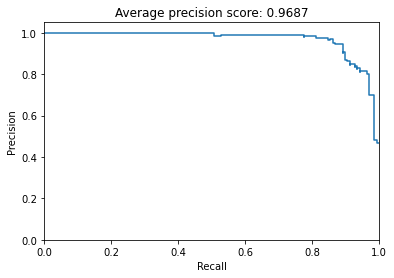

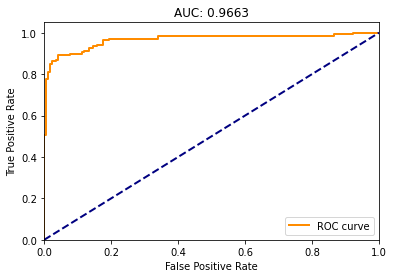

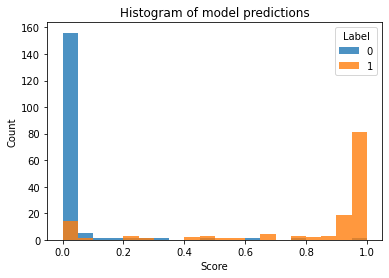

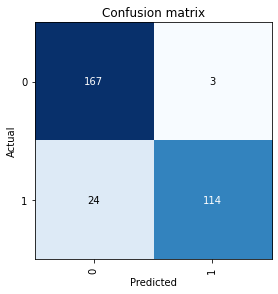

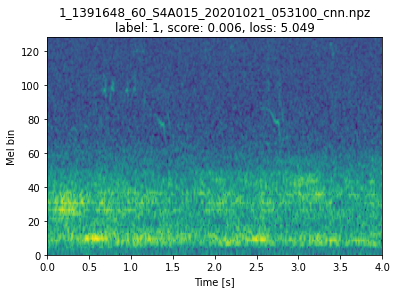

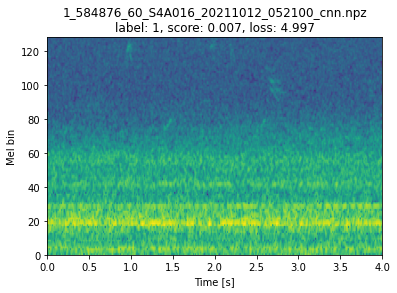

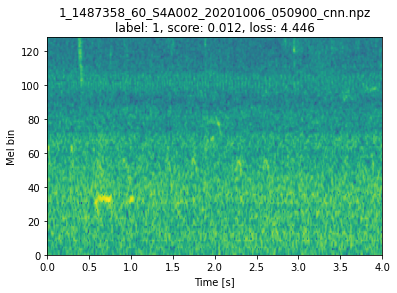

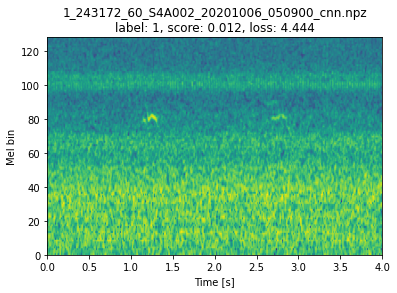

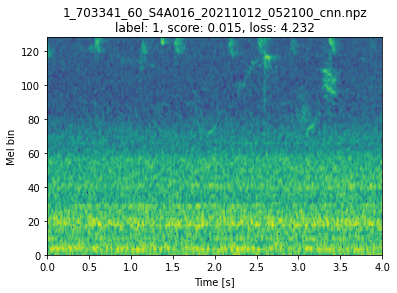

In [6]:
## EVALUATION OF THE VALIDATION DATA - OPTIONAL ##
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import librosa
import os
from scipy.special import expit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import itertools
import model.utils as utils
import torch

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
    'Average precision score: {0:0.4f}'
    .format(average_precision))
    plt.show()

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(
    'AUC: {0:0.4f}'
    .format(roc_auc))
    plt.legend(loc="lower right")
    plt.show()

def plot_model_predictions_hist(y_true, y_scores, bins=20, alpha=0.8):
    plt.hist(y_scores[y_true==0], bins=bins, range=[0,1], alpha=alpha, label='0')
    plt.hist(y_scores[y_true==1], bins=bins, range=[0,1], alpha=alpha, label='1')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.legend(title='Label')
    plt.title('Histogram of model predictions')
    plt.show()

# https://github.com/fastai/fastai1/blob/master/fastai/train.py#L191
def plot_confusion_matrix(y_true, y_scores, score_threshold=0.5):
    cm = confusion_matrix(y_true, np.where(y_scores>=score_threshold, 1, 0))
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, [0,1], rotation=90)
    plt.yticks(tick_marks, [0,1], rotation=0)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ax = fig.gca()
    ax.set_ylim(2-.5,-.5)
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.grid(False)
    plt.show()

# plot mel-spectrograms of the audio clips with the largest loss
def plot_top_losses(df, params, k=5):    
    ind = np.argpartition(-df["loss"], range(k))[:k]
    for i in ind:
        file = df["file"].iloc[i]
        score = df["scores"].iloc[i]
        label = df["targets"].iloc[i]
        loss = df["loss"].iloc[i]        
        data = np.load(file)
        x, sr = data['x'], data['sr']
        S = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=params.window_size, hop_length=params.hop_length, 
                                           n_mels=params.n_mels,
                                           fmin=params.fmin, fmax=params.fmax,
                                           power=params.power)
        S_dB = librosa.power_to_db(S, ref=np.max, top_db=params.top_db)        
        times = librosa.frames_to_time(np.arange(S.shape[1]), sr=sr, hop_length=params.hop_length, n_fft=None)
        extent = [times[0], times[-1], 0, S.shape[0]]
        plt.imshow(S_dB, extent=extent, origin='lower', aspect='auto')
        plt.xlabel('Time [s]')
        plt.ylabel('Mel bin')
        plt.title('{0}\nlabel: {1}, score: {2:0.3f}, loss: {3:0.3f}'.format(os.path.basename(file),
                                                                            int(label),
                                                                            score,
                                                                            loss))
        plt.show()

def save_fn_fp(df, model_dir, threshold=0.5):
    df["FP"] = np.where((df["targets"] == 0) & (df["scores"] >= threshold), 1, 0)
    df["FN"] = np.where((df["targets"] == 1) & (df["scores"] < threshold), 1, 0)
    fp = df[df["FP"] == 1].sort_values(by=["loss"], ascending=False)
    fn = df[df["FN"] == 1].sort_values(by=["loss"], ascending=False)    
    outfile = os.path.join(model_dir, 'FP.csv')
    fp.to_csv(outfile, index=False)
    print('FPs written to: {}'.format(outfile))
    outfile = os.path.join(model_dir, 'FN.csv')
    fn.to_csv(outfile, index=False)
    print('FNs written to: {}'.format(outfile))

########################################################
########################################################
def main(model_dir):
    # Load the parameters from json file
    json_path = os.path.join(model_dir, 'params.json')
    assert os.path.isfile(
        json_path), "No json configuration file found at {}".format(json_path)
    params = utils.Params(json_path)
    # Load the data from CSV file
    csv_path = os.path.join(model_dir, 'outputs_test_best.csv')
    assert os.path.isfile(
        csv_path), "No CSV file found at {}".format(csv_path)
    df = pd.read_csv(csv_path)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(torch.from_numpy(df["logits"].values), 
                                                                torch.from_numpy(df["targets"].values),
                                                                reduction='none').numpy()
    df["loss"] = loss
    df["scores"] = df["logits"].apply(expit)
    y_true = df["targets"].astype(int)
    y_scores = df["scores"]
    save_fn_fp(df, model_dir)
    plot_precision_recall_curve(y_true, y_scores)
    plot_roc_curve(y_true, y_scores)
    plot_model_predictions_hist(y_true, y_scores)
    plot_confusion_matrix(y_true, y_scores)
    plot_top_losses(df, params)

model_dir = 'experiments/retraining_model'
main(model_dir)